In [30]:
## Necessary imports for data vis
import pandas as pd
import numpy as np
from neurodsp import filt
import random
import matplotlib.pyplot as plt
import scipy.signal as signal # For filtering

## Potentially necessary imports (uncomment if you need them)
# import os
# import sys
# import time

# from os import listdir
# from generate_epoch import * # make sure to have this file inside the ML folder
# from scipy.signal import butter, sosfiltfilt, sosfreqz  # for filtering

# # for models:
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

# Note: try rerunning this cell if an error pops up

## Helper functions

In [3]:
def getOutputLabelsAndEpochTimes(event_df):
    # Generates the ordered list of output labels and epoch time pairs
    # Input: event_df -- the event dataframe from the csv file
    # Output: 
    #    output_labels -- [1, 2, 4, 3, etc] where the integers correspond to the trial type encoded
    #    epoch_times -- [[<timestamp of start>, <timestamp of end>], [<timestamp of start>, <timestamp of end>], etc]
    
    output_labels = []
    epoch_times = []
    current_epoch = []
    for index, row in event_df.iterrows():
        event_info = row['EventStart'].split("_")
        if event_info[0] == 'start': 
            output_labels.append(int(event_info[1]))
            current_epoch.append(row['time'])
        else :
            current_epoch.append(row['time'])
            epoch_times.append(list(current_epoch))
            current_epoch = []
    return np.array(output_labels), np.array(epoch_times)

In [4]:
def getEEGEpochs(epoch_times, eeg_df, target_num_trials=1000):
    # Slices and generates the epochs in the eeg_df given the epoch_times
    # Input: 
    #    epoch_times: [[<timestamp of start>, <timestamp of end>], [<timestamp of start>, <timestamp of end>], etc]
    #    eeg_df: dataframe from csv file
    # Output: 
    #    a numpy array containing eeg_epochs (#epoch, #chans, #timepoints)
    eeg_epochs = []
    for epoch_time in epoch_times: 
        sub_df = eeg_df[(eeg_df['time'] > epoch_time[0]) & (eeg_df['time'] < epoch_time[1])]
        sub_df = sub_df.drop(columns=['time'])
        num_above = len(sub_df) - target_num_trials
        if num_above >= 0:
            epoch = np.array(sub_df.values[num_above // 2: len(sub_df) - num_above // 2])[:1000]
            eeg_epochs.append(epoch.T)
            if len(epoch) != 1000:
                print("Warning: Potential off by 1 error. Found trail with != 1000 samples:", len(epoch))
        else: 
            print("Warning: Epoch with less than", target_num_trials, "eeg samples")
    return np.array(eeg_epochs)


In [5]:
def filterEEG(eeg_data, fs=250, f_range=(0.5, 50)):
    sig_filt = filt.filter_signal(eeg_data, fs, 'bandpass', f_range, filter_type='iir', butterworth_order=2)
    test_sig_filt = filt.filter_signal(sig_filt, fs, 'bandstop', (58, 62), n_seconds=1)
    num_nans = sum(np.isnan(test_sig_filt))
    sig_filt = np.concatenate(([0]*(num_nans // 2), sig_filt, [0]*(num_nans // 2)))
    sig_filt = filt.filter_signal(sig_filt, fs, 'bandstop', (58, 62), n_seconds=1)
    sig_filt = sig_filt[~np.isnan(sig_filt)]
    return sig_filt

In [6]:
def getFilteredEpochs(eeg_epochs):
    # eeg_epochs is in (#trials, #timepoints, #channels)
    filtered_eeg_epochs = []
    for eeg_epoch in eeg_epochs: 
        filtered_epoch = []
        for i in range(len(eeg_epoch)):  
            filtered_eeg = filterEEG(eeg_epoch[i])
            filtered_epoch.append(filtered_eeg)
        filtered_epoch = np.array(filtered_epoch)
        filtered_eeg_epochs.append(filtered_epoch)
    return np.array(filtered_eeg_epochs)

In [7]:
def plotPSD(freq, psd, fs=250, pre_cut_off_freq=0, post_cut_off_freq=120, label=None):
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    pre_cut = int(len(freq)*(pre_cut_off_freq / freq[-1]))
    post_cut = int(len(freq)*(post_cut_off_freq / freq[-1]))
    plt.plot(freq[pre_cut:post_cut], (psd[pre_cut:post_cut]), label=label)

In [8]:
def getFreqPSDFromEEG(eeg_data, fs=250):
    freq, psd = signal.periodogram(eeg_data, fs=int(fs), scaling='spectrum')
    return freq, psd

In [9]:
from neurodsp.spectral import compute_spectrum
def getMeanFreqPSD(eeg_data, fs=250):
    freq_mean, psd_mean = compute_spectrum(eeg_data, fs, method='welch', avg_type='mean', nperseg=fs*2)
    return freq_mean, psd_mean

In [10]:
def plotPSD_fromEEG(eeg_data, fs=250, pre_cut_off_freq=0, post_cut_off_freq=120, label=None):
    freq, psd = signal.periodogram(eeg_data, fs=int(fs), scaling='spectrum')
    plotPSD(freq, psd, fs, pre_cut_off_freq, post_cut_off_freq, label)

In [11]:
## Create DF for each of these, columns are channels, each row is a trial run
def getDF(epochs, labels, times, chans):
    data_dict = {}
    for i, label in enumerate(labels): 
        start_time = times[i][0]
        if 'start_time' not in data_dict: 
            data_dict['start_time'] = list()
        data_dict['start_time'].append(start_time)
        
        if 'event_type' not in data_dict:
            data_dict['event_type'] = list()
        data_dict['event_type'].append(label)
        
        for ch in range(len(chans)): 
            if chans[ch] not in data_dict:
                data_dict[chans[ch]] = list() 
            data_dict[chans[ch]].append(epochs[i][ch])
        
    return pd.DataFrame(data_dict)

### Main

In [12]:
# def getDataFrame(eeg_filename, event_filename) :
eeg_filename = "./data/eeg_data 30_per.csv"
event_filename = "./data/event_data 30_per.csv"

chans = ['C4','C2', 'C1', 'C3']
eeg_df = pd.read_csv(eeg_filename)
eeg_df.columns=['time','C4', 'C2', 'C1', 'C3']

event_df = pd.read_csv(event_filename)
event_df.columns=['time', 'EventStart'] # 1 = left, 2 = right, 3 = foot, 4 = idle


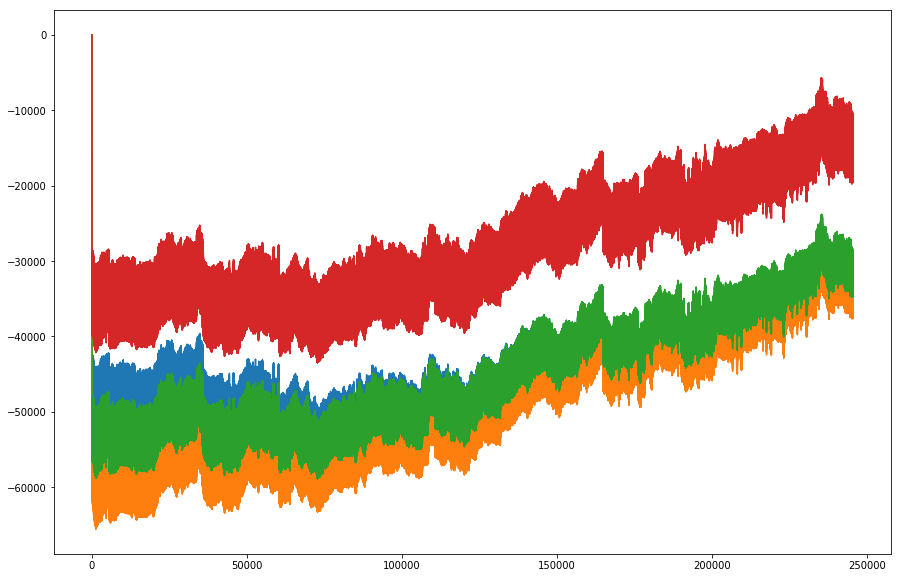

/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/filter.py:86: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/iir.py:136: UserWarning: IIR filters are not recommended other than for notch filters.
  warn('IIR filters are not recommended other than for notch filters.')
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/utils.py:65: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 

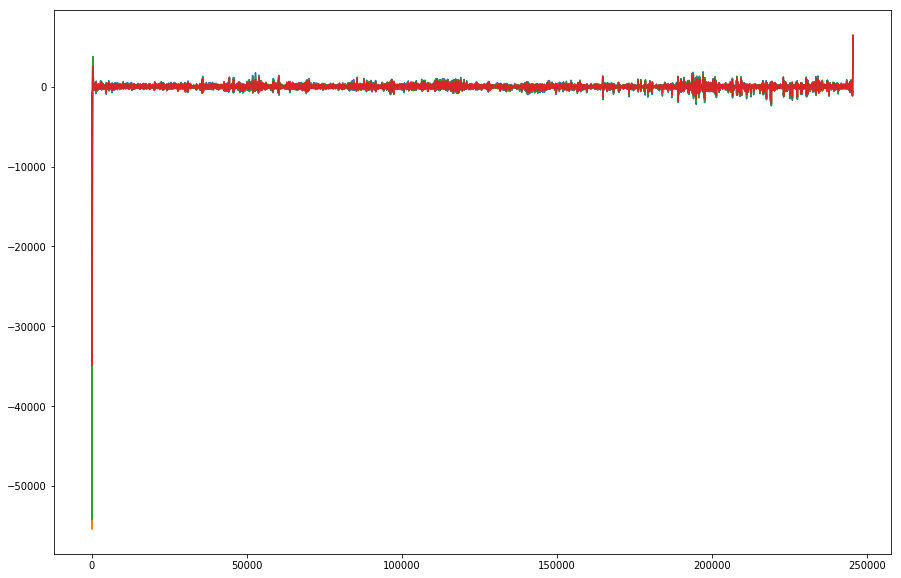

In [13]:
# Plot full data
plt.figure(figsize=(15,10))
for chan in chans:
    plt.plot(eeg_df[chan].values)
plt.show()

# Plot filtered full data
filtered_df = eeg_df.copy()

plt.figure(figsize=(15,10))
for chan in chans:
    filtered_df[chan] = filterEEG(filtered_df[chan].values)
    plt.plot(filtered_df[chan].values)

In [17]:
# Process dfs to get labels, raw eeg epochs, epochs of filtered eeg data, filtered epoch data
output_labels, epoch_times = getOutputLabelsAndEpochTimes(event_df)
raw_eeg_epochs = getEEGEpochs(epoch_times, eeg_df) # Raw eeg epochs
filter_then_epoch_epochs = getEEGEpochs(epoch_times, filtered_df) # Epoched after filtering
epoch_then_filter_epochs = getFilteredEpochs(raw_eeg_epochs) # Filtered after epoching


In [18]:
# Check shape: should be (#trials, #chans, # timepoints)
raw_eeg_epochs.shape

(120, 4, 1000)

In [19]:
# Visualize output labels (1=left, 2=right, 3=foot, 4=idle)
output_labels

array([3, 1, 1, 1, 4, 4, 3, 4, 1, 3, 2, 1, 1, 4, 1, 2, 2, 4, 4, 2, 3, 2,
       3, 2, 4, 1, 2, 3, 3, 3, 4, 4, 1, 3, 2, 3, 1, 1, 3, 4, 4, 3, 3, 2,
       2, 3, 3, 4, 2, 4, 1, 4, 4, 3, 1, 1, 4, 2, 1, 1, 3, 1, 1, 1, 4, 2,
       2, 4, 4, 1, 4, 2, 4, 2, 4, 1, 3, 2, 2, 1, 2, 1, 3, 1, 3, 3, 3, 2,
       4, 2, 4, 3, 1, 2, 3, 4, 4, 4, 2, 4, 2, 1, 3, 3, 1, 2, 3, 4, 4, 1,
       3, 3, 1, 2, 2, 1, 2, 2, 3, 2])

In [20]:
# Create DataFrames
raw_eeg_epoch_df = getDF(raw_eeg_epochs, output_labels, epoch_times, chans)
filter_then_epoch_df = getDF(filter_then_epoch_epochs, output_labels, epoch_times, chans)
epoch_then_filter_df = getDF(epoch_then_filter_epochs, output_labels, epoch_times, chans)
epoch_then_filter_df.head()

,start_time,event_type,C4,C2,C1,C3
0,1.601744e+09,3,"[213.51552607643978, -956.6005694966476, -876....","[1046.8777249609045, 60.46235051777022, 582.45...","[866.6267760041843, -57.30260671646343, 344.19...","[1062.7067338068791, -160.7525293177138, 344.6..."
1,1.601744e+09,1,"[1246.8758042720992, 3581.4106024231046, 4087....","[1526.4641251542475, 5432.691300708791, 6060.8...","[1372.4004466394606, 4645.390402174456, 5193.0...","[1737.4331855946882, 5968.803806293188, 6684.5..."
2,1.601744e+09,1,"[-1459.6140223417267, -3585.7524564876758, -43...","[-2586.362960861316, -6903.469939572756, -8136...","[-2130.2598955708086, -5676.554685691095, -670...","[-2755.924385211308, -7297.067243835943, -8627..."
3,1.601744e+09,1,"[1659.7167021517512, 3874.5536316336525, 4593....","[2465.63314213007, 6830.408417277991, 8002.528...","[2202.2466191472645, 5786.167062430321, 6771.0...","[2775.3031438020676, 7383.500868267241, 8656.1..."
4,1.601744e+09,4,"[1381.096273772812, 3607.180226789919, 4319.22...","[2351.66940526027, 6687.606381065537, 7840.934...","[1955.1394126940652, 5525.293751588703, 6496.3...","[2587.2204679370207, 7208.136558779917, 8467.2..."


In [21]:
psds_only_one_type={}
freqs_only_one_type={}
for i, row in filter_then_epoch_df[filter_then_epoch_df["event_type"] == 1].iterrows(): 
    for ch in chans: 
        if ch not in psds_only_one_type: 
            psds_only_one_type[ch] = list()
            freqs_only_one_type[ch] = list()
        f, p = getFreqPSDFromEEG(row[ch])
        psds_only_one_type[ch].append(p)
        freqs_only_one_type[ch].append(f)
avg_psds_one_type = {}
for ch in chans:
    psds_only_one_type[ch] = np.array(psds_only_one_type[ch])
    avg_psds_one_type[ch] = np.mean(psds_only_one_type[ch], axis=0)

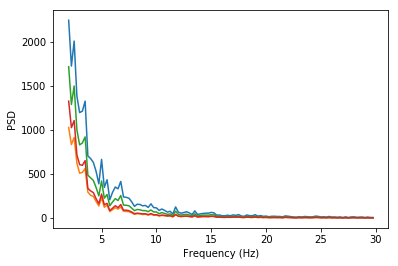

In [23]:
# View Average PSDs
for ch in chans[:]: 
    plotPSD(freqs_only_one_type[chans[0]][0], avg_psds_one_type[ch],pre_cut_off_freq=2, post_cut_off_freq=30)
    

# For testing with ML Models to make sure output is fine

In [24]:
X = raw_eeg_epochs
Y = output_labels

In [25]:
#Default 4:1 split
#Suffle
temp=list(zip(Y, X))
random.shuffle(temp)
Y, X = zip(*temp)
#Split train/test
X_train = np.array(X[:int(len(X)*4/(4+1))])
X_test = np.array(X[int(len(X)*4/(4+1)):])
Y_train = np.array(Y[:int(len(Y)*4/(4+1))])
Y_test = np.array(Y[int(len(Y)*4/(4+1)):])

class myModel:
    def __init__(self):
        pass
    def fit(X, Y):
        pass
    def predict(X):
        pass
    
class XDawnLRModel(myModel): # XDAWN Covariance Preprocessing + Linear Regression Classifier
    def __init__(self):
        super().__init__()
        self.XC = XdawnCovariances(nfilter = 1) # the number of filters can be changed
        self.logreg = LogisticRegression()
        
    def fit(self, X, Y):
        X_transformed = self.XC.fit_transform(X, Y)
        X_transformed = TangentSpace(metric='riemann').fit_transform(X_transformed)
        self.logreg.fit(X_transformed,Y)
        
    def predict(self, X):
        X_transformed = self.XC.transform(X)
        X_transformed = TangentSpace(metric='riemann').fit_transform(X_transformed)
        return self.logreg.predict(X_transformed)

model = XDawnLRModel()
model.fit(X_train, Y_train)
#return model

/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [26]:
Y_pred = model.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           1       0.50      0.50      0.50         6
           2       0.60      0.50      0.55         6
           3       0.50      0.33      0.40         9
           4       0.00      0.00      0.00         3

    accuracy                           0.38        24
   macro avg       0.40      0.33      0.36        24
weighted avg       0.46      0.38      0.41        24



In [27]:
Y_test

array([3, 3, 2, 3, 1, 4, 2, 3, 4, 1, 1, 1, 2, 3, 2, 2, 1, 3, 3, 3, 4, 2,
       1, 3])

In [28]:
Y_pred

array([3, 3, 2, 1, 4, 2, 2, 4, 3, 1, 1, 1, 1, 2, 4, 3, 3, 4, 4, 4, 1, 2,
       4, 3])

In [29]:
sum(Y_test == Y_pred)/len(Y_test)

0.375